In [1]:
%pylab inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import numpy.random as rng
import pandas.io.data as web
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
# we modify this data organizing slightly to get two symbols
def get_prices(symbol):
    start, end = '2007-05-02', '2016-04-11'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Adj Close']
    prices=prices.astype(float)
    return prices

def get_returns(prices):
        return ((prices-prices.shift(-1))/prices)[:-1]
    
def get_data(list):
    l = []
    for symbol in list:
        rets = get_returns(get_prices(symbol))
        l.append(rets)
    return np.array(l).T

def sort_data(rets):
    ins = []
    outs = []
    for i in range(len(rets)-100):
        ins.append(rets[i:i+100].tolist())
        outs.append(rets[i+100])
    return np.array(ins), np.array(outs)
        


In [3]:
symbol_list = ['C', 'GS']
rets = get_data(symbol_list)
ins, outs = sort_data(rets)
ins = ins.transpose([0,2,1]).reshape([-1, len(symbol_list) * 100])
div = int(.8 * ins.shape[0])
train_ins, train_outs = ins[:div], outs[:div]
test_ins, test_outs = ins[div:], outs[div:]

#normalize inputs
train_ins, test_ins = train_ins/np.std(ins), test_ins/np.std(ins)

In [4]:
sess = tf.InteractiveSession()

In [137]:
positions = tf.constant([-1,0,1]) #long, neutral or short
num_positions = 3
num_symbols = len(symbol_list)
num_samples = 20


# define placeholders 
x = tf.placeholder(tf.float32, [None, num_symbols * 100])
y_ = tf.placeholder(tf.float32, [None,  num_symbols])

# define trainable variables
W = tf.Variable(tf.random_normal([num_symbols * 100, num_positions * num_symbols]))
b = tf.Variable(tf.random_normal([num_positions * num_symbols]))

# we define our model: y = W*x + b
y = tf.matmul(x, W) + b # y is tensor of shape [num_inputs, num_positions * len(symbol_list)]
# a row of y will look like [prob_symbol_1_short, prob_symbol_1_neutral, prob_symbol_1_long, prob_symbol_2_short, ...]
# note that they are not really probabilities because I did not perform a softmax yet


# loop through symbol, taking the columns for each symbol's bucket together
pos = {}
sample_n = {}
sample_mask = {}
symbol_returns = {}
relevant_target_column = {}
for i in range(num_symbols):
    # isolate the buckets relevant to the symbol and get a softmax as well
    symbol_probs = y[:,i*num_positions:(i+1)*num_positions]
    symbol_probs_softmax = tf.nn.softmax(symbol_probs) # softmax[i, j] = exp(logits[i, j]) / sum(exp(logits[i]))
    # sample probability to chose our policy's action
    sample = tf.multinomial(tf.log(symbol_probs_softmax), num_samples)#sample = tf.argmax(symbol_probs_softmax, 1) #use a real sample
        #pos[i] = tf.reshape(sample, [-1]) - 1   # choose(-1,0,1)
        # get returns by multiplying the policy (position taken) by the target return for that day
        #symbol_returns[i] = tf.mul(tf.cast(pos[i], float32),  y_[:,i])
    # isolate the probability of the selected policy (for use in calculating gradient)
    for sample_iter in range(num_samples):
        sample_n[i*num_samples + sample_iter] = sample[:,sample_iter]
        pos[i*num_samples + sample_iter] = tf.reshape(sample_n[i*num_samples + sample_iter], [-1]) - 1
        symbol_returns[i*num_samples + sample_iter] = tf.mul(
                                                            tf.cast(pos[i*num_samples + sample_iter], float32), 
                                                             y_[:,i])
        
        sample_mask[i*num_samples + sample_iter] = tf.cast(tf.reshape(tf.one_hot(sample_n[i*num_samples + sample_iter], 3), [-1,3]), float32)
        relevant_target_column[i*num_samples + sample_iter] = tf.reduce_sum(
                                                    symbol_probs * sample_mask[i*num_samples + sample_iter],1)
    


daily_returns_by_symbol_ = tf.concat(1, [tf.reshape(t, [-1,1]) for t in symbol_returns.values()])
daily_returns_by_symbol = tf.transpose(tf.reshape(daily_returns_by_symbol_, [-1,2,num_samples]), [0,2,1]) #[?,5,2]
daily_returns = tf.reduce_mean(daily_returns_by_symbol, 2) # [?,5]

total_return = tf.reduce_prod(daily_returns+1, 0)
z = tf.ones_like(total_return) * -1
total_return = tf.add(total_return, z)


ann_vol = tf.mul(
    tf.sqrt(tf.reduce_mean(tf.pow((daily_returns - tf.reduce_mean(daily_returns, 0)),2),0)) ,
    np.sqrt(252)
    )
sharpe = tf.div(total_return, ann_vol)
#Maybe metric slicing later
#segment_ids = tf.ones_like(daily_returns[:,0])
#partial_prod = tf.segment_prod(daily_returns+1, segment_ids)


training_target_cols = tf.concat(1, [tf.reshape(t, [-1,1]) for t in relevant_target_column.values()])
ones = tf.ones_like(training_target_cols)
gradient_ = tf.nn.sigmoid_cross_entropy_with_logits(training_target_cols, ones)

gradient = tf.transpose(tf.reshape(gradient_, [-1,2,num_samples]), [0,2,1]) #[?,5,2]

#cost = tf.mul(gradient , daily_returns_by_symbol_reshaped)
#cost = tf.mul(gradient , tf.expand_dims(daily_returns, -1))
#cost = tf.mul(gradient , tf.expand_dims(total_return, -1))
cost = tf.mul(gradient , tf.expand_dims(sharpe, -1))

optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(cost)
costfn = tf.reduce_mean(cost)







# calculate the performance metrics for the data chosen
#daily_returns_by_symbol = tf.concat(1, [tf.reshape(t, [-1,1]) for t in symbol_returns.values()])
#daily_returns = tf.reduce_sum(daily_returns_by_symbol,1)/2
#total_return = tf.reduce_prod(daily_returns + 1)
#ann_vol = tf.mul(
 #   tf.sqrt(tf.reduce_mean(tf.pow((daily_returns - tf.reduce_mean(daily_returns)),2))) ,
 #   np.sqrt(252)
 #   )
#sharpe = total_return / ann_vol

'''
# since we only train the sampled classes, we will combine them so that we can feed them into cross entropy
training_target_cols = tf.concat(1, [tf.reshape(t, [-1,1]) for t in relevant_target_column.values()])
# we want to either push the gradient toward our selection or away from it. We use these ones to find the direction
#     of the gradient, which we will then multiply by our fitness function
ones = tf.ones_like(training_target_cols)

# this isnt actuall a gradient, but karpathy sort of calls it one. Since it is a tensor it sort of is a gradient anyway
gradient = tf.nn.sigmoid_cross_entropy_with_logits(training_target_cols, ones)

# how should we do this step? it depends how we want to group our results. Choose your own adventure here by uncommenting a cost fn
# this is the most obvious: we push each weight to what works or not. Try it out...we're gonna be RICH!!!! oh, wait...
#cost = tf.mul(gradient , daily_returns_by_symbol)
# this takes the overall daily return and pushes the weights so that the overall day wins. Again, it overfits enormously
#cost = tf.mul(gradient , tf.reshape(daily_returns,[-1,1]))
# this multiplies every gradient by the overall return. If the strategy won for the past ten years, we do more of it and vice versa
cost = tf.mul(gradient , total_return)
# for printing
costfn = tf.reduce_mean(cost)

# minimize the cost (push the weights where we want them to go)
optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(cost)
'''
print()

In [130]:
costfn
#gradient_
#total_return

<tf.Tensor 'Mean_50:0' shape=() dtype=float32>

In [113]:
ann_vol
total_return

<tf.Tensor 'Add_1:0' shape=(20,) dtype=float32>

In [149]:
# initialize variables to random values
init = tf.initialize_all_variables()
sess.run(init)
# run optimizer on entire training data set many times
train_size = train_ins.shape[0]
for epoch in range(2000):
    start = rng.randint(train_size-50)
    batch_size = rng.randint(2,75)
    end = min(train_size, start+batch_size)
    
    sess.run(optimizer, feed_dict={x: train_ins[start:end], y_: train_outs[start:end]})#.reshape(1,-1).T})
    # every 1000 iterations record progress
    if (epoch+1)%100== 0:
        t,s, c = sess.run([ total_return, sharpe, costfn], feed_dict={x: train_ins, y_: train_outs})#.reshape(1,-1).T})
        t = np.mean(t)
        s = np.mean(s)
        print("Epoch:", '%04d' % (epoch+1), "cost=",c, "total return=", "{:.9f}".format(t), 
             "sharpe=", "{:.9f}".format(s))
        #print(t)

Epoch: 0100 cost= 4.0075 total return= 0.410749108 sharpe= 1.227803946
Epoch: 0200 cost= 5.79791 total return= 0.325742573 sharpe= 0.908009708
Epoch: 0300 cost= 29.9439 total return= 1.916382551 sharpe= 5.669203281
Epoch: 0400 cost= 30.9742 total return= 2.846206665 sharpe= 8.231985092
Epoch: 0500 cost= 14.2515 total return= 2.010600805 sharpe= 5.734219074
Epoch: 0600 cost= 36.9297 total return= 2.298950195 sharpe= 6.386272430
Epoch: 0700 cost= 17.9175 total return= 1.090037107 sharpe= 2.921367884
Epoch: 0800 cost= 22.0439 total return= 0.870501816 sharpe= 2.314534664
Epoch: 0900 cost= 265.804 total return= 5.780017376 sharpe= 15.342338562
Epoch: 1000 cost= 336.977 total return= 7.407339573 sharpe= 18.710979462
Epoch: 1100 cost= 261.297 total return= 7.243052483 sharpe= 18.231023788
Epoch: 1200 cost= 166.946 total return= 4.330142975 sharpe= 11.005815506
Epoch: 1300 cost= 133.772 total return= 3.356940508 sharpe= 8.886281013
Epoch: 1400 cost= 130.561 total return= 3.171287537 sharpe= 8

In [150]:
# in sample results
#init = tf.initialize_all_variables()
#sess.run(init)
d, t = sess.run([daily_returns, total_return], feed_dict={x: train_ins, y_: train_outs})

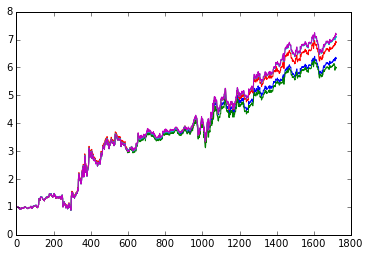

In [151]:
# equity curve
for i in range(5):
    plot(np.cumprod(d[:,[i]]+1))

In [152]:
#out of sample results
d, t = sess.run([daily_returns, total_return], feed_dict={x: test_ins, y_: test_outs})

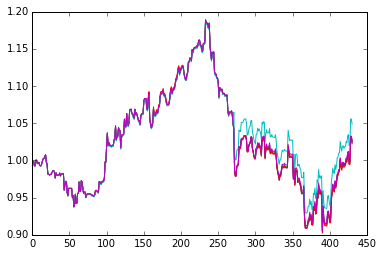

In [153]:
#out of sample results
for i in range(5):
    plot(np.cumprod(d[:,[i]]+1))